# Capstone Project : XGboost

In this notebook, we build a XGboost classifier to predict the likelihood of churn given customer demographics, customer account information and customer services.

In [13]:
# Import Packages
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
from matplotlib.colors import ListedColormap
import matplotlib.colors as colors
import matplotlib.cm as cmx
import matplotlib.pyplot as plt
from pylab import rcParams
import math

from imblearn.pipeline import Pipeline as pl
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBClassifier
from sklearn import metrics
from sklearn.metrics import roc_curve, auc, precision_recall_curve, cohen_kappa_score
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split, GridSearchCV
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

from yellowbrick.classifier import DiscriminationThreshold

import warnings
warnings.filterwarnings('ignore')

# global set
pd.set_option('display.max_columns', None)

In [14]:
#Define the plot Function
def result(model, X_train, y_train, X_test, y_test, train_result, clf_name):
    """ This function calculates different metrics to show the model's performance on both training and test data.
    This functoin also shows the confusion matrix, and plots the ROC and PR curves.
    
    Parameters
    ----------
    model (dtype: sklearn.model_selection._search.GridSearchCV) : The classifier model
    train_result (dtype: boolean): If YES, calculate results for train data
    clf_name (dtype: str): Name of the classifier
    """
    if train_result:
        y_pred_train = model.predict(X_train) # class prediction
        y_pred_train_prob = model.predict_proba(X_train) # probability of each class prediction
        print("#####################")
        print("Train data")
        print("#####################")
        print("F1: ", metrics.f1_score(y_train, y_pred_train))
        print("Cohen Kappa: ", metrics.cohen_kappa_score(y_train, y_pred_train))
        print("Brier: ", metrics.brier_score_loss(y_train, y_pred_train))
        print("LogLoss: ", metrics.log_loss(y_train, y_pred_train_prob))
        print(metrics.classification_report(y_train, y_pred_train))
        print(metrics.confusion_matrix(y_train, y_pred_train))
    else:
        pass
    
    y_pred_test = model.predict(X_test)
    y_pred_test_prob = model.predict_proba(X_test)
    print("#####################")
    print("Test data")
    print("#####################")
    print("F1: ", metrics.f1_score(y_test, y_pred_test))
    print("Cohen Kappa: ", metrics.cohen_kappa_score(y_test, y_pred_test))
    print("Brier: ", metrics.brier_score_loss(y_test, y_pred_test))
    print("LogLoss: ", metrics.log_loss(y_test, y_pred_test_prob))
    print(metrics.classification_report(y_test, y_pred_test))
    conf_matrix = metrics.confusion_matrix(y_test, y_pred_test)
    
    # Displaying the confusion matrix
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            ax.text(x=j, y=i, s=conf_matrix[i, j], va='center', ha='center', fontsize=24)

    plt.title('Confusion Matrix for %s' % clf_name, size=20)
    plt.xlabel('Predicted label', size=20)
    plt.ylabel('True label', size=20)
    ax.tick_params('x', labelsize = 20)
    ax.tick_params('y', labelsize = 20)
    plt.tight_layout()
    
    # ROC curve
    fig1, ax1 = plt.subplots(figsize=(8, 8))
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_test_prob[:, 1])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=1, label='Model Performance (area = %0.2f)' % (roc_auc))
    plt.plot([0, 1], 
             [0, 1], 
             '--', 
             color=(0.6, 0.6, 0.6), 
             label='Luck')
    
    plt.plot([0, 0, 1], 
             [0, 1, 1], 
             lw=2,
             linestyle=':',
             color='black',
             label='Perfect Performance')
        
    plt.xlim([-0.02, 1.02])
    plt.ylim([-0.02, 1.02])
    plt.xlabel('False Positive Rate', size=20)
    plt.ylabel('True Positive Rate', size=20)
    plt.title('Receiver Operating Characteristic for %s' % clf_name, size=20)
    plt.xticks(size = 20)
    plt.yticks(size = 20)
    plt.legend(loc="lower right", fontsize=18)
    
    # PR curve
    fig2, ax2 = plt.subplots(figsize=(8, 8))
    prec, recall, thresholds = precision_recall_curve(y_test, y_pred_test_prob[:, 1])
    #pr_auc = auc(prec, recall)
    plt.plot(recall, prec, lw=1, label='Model Performance (area = %0.2f)' % 
             (metrics.average_precision_score(y_test, y_pred_test_prob[:, 1])))    
    plt.xlim([-0.02, 1.02])
    plt.ylim([-0.02, 1.02])
    plt.xlabel('Recall', size=20)
    plt.ylabel('Precision', size=20)
    plt.title('PR Curve for %s' % clf_name, size=20)
    plt.xticks(size = 20)
    plt.yticks(size = 20)
    plt.legend(loc="top right", fontsize=18)

# Preprocessing the Data
We have acquired and cleaned the data in this IPython Notebook. All the features were used for this analysis. Let's get the data prepared for modeling.

In [15]:
# global set
pd.set_option('display.max_columns', None)

# Load the data
telco = pd.read_csv("telco_eda.csv") 

# recode the features
# tranform to dummy variable
binvar = ['SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 
          'PaperlessBilling', 'Churn']
for col in binvar:
    telco[col] = telco[col].apply(lambda x: 1 if x=='Yes' else 0 )
    
transformed_telco = pd.get_dummies(telco)
transformed_telco.shape

# Train/test split
X = transformed_telco.drop(["Churn"], axis=1).values
y = transformed_telco.Churn.astype(int).values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    random_state=42, stratify = y)

# XGboost - Random Under Sampling, Scaling 

In [13]:
%%time

# Steps for pipeline
steps = [("rus", RandomUnderSampler(random_state=30)),
         ("scaler", MinMaxScaler(feature_range=(0,1))),
         ("model", XGBClassifier())]
pipe = pl(steps)

# Parameters
param_grid = dict(model__learning_rate = [0.10, 0.15, 0.20],
                  model__max_depth = [5, 10, 15, 20],
                  model__gamma = [ 0.1, 0.2, 0.3, 0.4 ],
                  model__colsample_bytree = [0.3, 0.4, 0.5 , 0.7]
                 )


# For CV in grid search
cv = StratifiedShuffleSplit(n_splits = 5, test_size = 0.2, random_state = 20)

# Setting up the grid search
XGBrus  = GridSearchCV(pipe, 
                       param_grid = param_grid, 
                       verbose = 3,
                       cv = cv,
                       n_jobs=-1,
                       scoring='average_precision',
                       iid=False)

# Training using CV
XGBrus.fit(X_train, y_train)

Fitting 5 folds for each of 192 candidates, totalling 960 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   35.8s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  9.1min
[Parallel(n_jobs=-1)]: Done 960 out of 960 | elapsed: 11.6min finished


CPU times: user 6.6 s, sys: 531 ms, total: 7.13 s
Wall time: 11min 38s


GridSearchCV(cv=StratifiedShuffleSplit(n_splits=5, random_state=20, test_size=0.2,
            train_size=None),
             error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('rus',
                                        RandomUnderSampler(random_state=30,
                                                           replacement=False,
                                                           sampling_strategy='auto')),
                                       ('scaler',
                                        MinMaxScaler(copy=True,
                                                     feature_range=(0, 1))),
                                       ('model',
                                        XGBClassifier(base_score=0.5,
                                                      booster='gbtree',
                                                      co...
                                                      scale_pos_weight=1,
        

In [14]:
XGBrus.best_params_

{'model__colsample_bytree': 0.3,
 'model__gamma': 0.3,
 'model__learning_rate': 0.1,
 'model__max_depth': 5}

#####################
Test data
#####################
F1:  0.6077235772357723
Cohen Kappa:  0.4148919207763777
Brier:  0.27434257285003555
LogLoss:  0.5236581015746773
              precision    recall  f1-score   support

           0       0.91      0.70      0.79      1033
           1       0.49      0.80      0.61       374

    accuracy                           0.73      1407
   macro avg       0.70      0.75      0.70      1407
weighted avg       0.80      0.73      0.74      1407



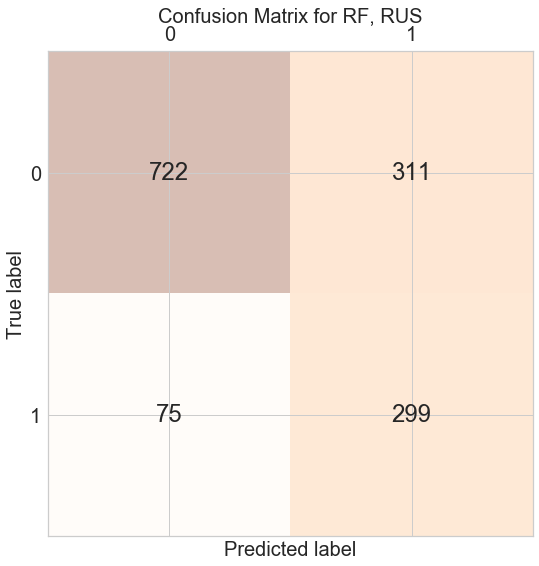

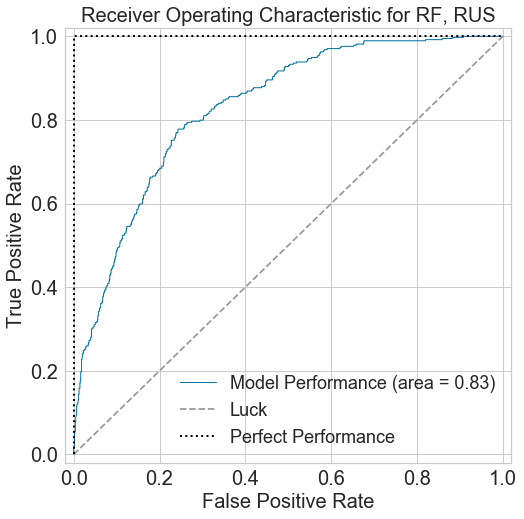

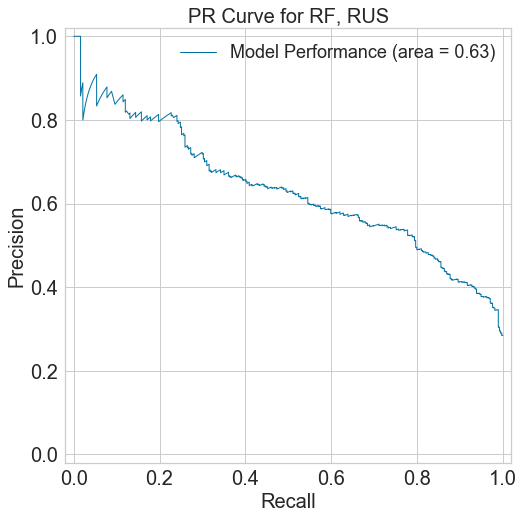

In [16]:
result(XGBrus, X_train, y_train, X_test, y_test, 
       train_result=False, clf_name="RF, RUS")

# XGboost - Scaling, Using Class Weight

In [5]:
%%time
# Steps for pipeline
steps = [("scaler", MinMaxScaler(feature_range=(0,1))),
         ("model", XGBClassifier())]
pipe = pl(steps)

# Parameters
param_grid = dict(model__learning_rate = [0.10],
                  model__max_depth = [5, 10, 15],
                  model__gamma = [ 0.1, 0.2, 0.3, 0.4 ],
                  model__colsample_bytree = [ 0.4, 0.5, 0.7],
                  model__class_weight = ['balanced'])

# For CV in grid search
cv = StratifiedShuffleSplit(n_splits = 5, test_size = 0.2, random_state = 20)

# Setting up the grid search
XGBcw =GridSearchCV(pipe, 
                    param_grid = param_grid, 
                    verbose = 3,
                    cv = cv,
                    n_jobs=-1,
                    scoring='average_precision',
                    iid=False)

# Training using CV
XGBcw.fit(X_train, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   45.3s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  4.2min finished


CPU times: user 3.5 s, sys: 198 ms, total: 3.7 s
Wall time: 4min 12s


GridSearchCV(cv=StratifiedShuffleSplit(n_splits=5, random_state=20, test_size=0.2,
            train_size=None),
             error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('scaler',
                                        MinMaxScaler(copy=True,
                                                     feature_range=(0, 1))),
                                       ('model',
                                        XGBClassifier(base_score=0.5,
                                                      booster='gbtree',
                                                      colsample_bylevel=1,
                                                      colsample_bynode=1,
                                                      colsample_bytree=1,
                                                      gamma=0,
                                                      learning_rate=0.1,
                                                      max_d...
        

In [6]:
XGBcw.best_params_

{'model__class_weight': 'balanced',
 'model__colsample_bytree': 0.7,
 'model__gamma': 0.2,
 'model__learning_rate': 0.1,
 'model__max_depth': 5}

#####################
Test data
#####################
F1:  0.5862068965517241
Cohen Kappa:  0.451236159563173
Brier:  0.2046908315565032
LogLoss:  0.42605355116072047
              precision    recall  f1-score   support

           0       0.84      0.89      0.86      1033
           1       0.63      0.55      0.59       374

    accuracy                           0.80      1407
   macro avg       0.74      0.72      0.73      1407
weighted avg       0.79      0.80      0.79      1407



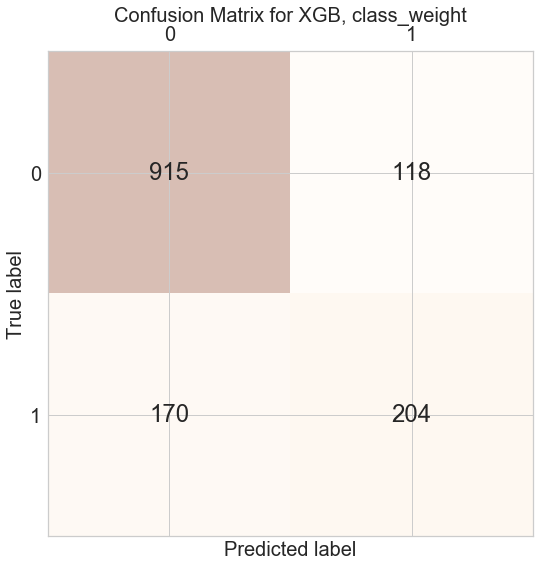

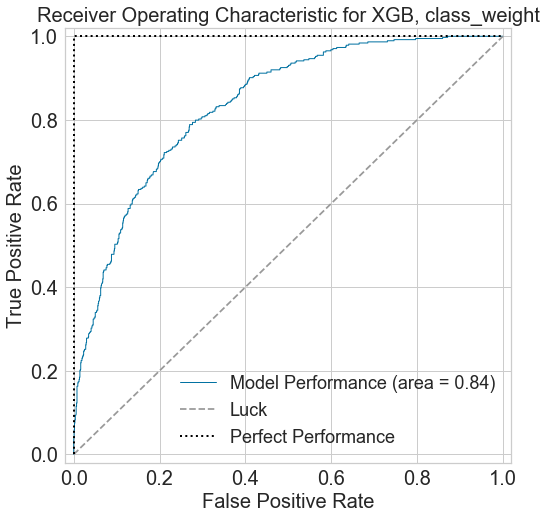

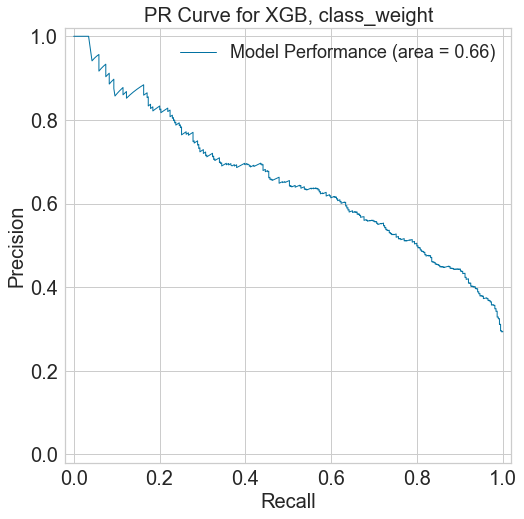

In [10]:
result(XGBcw, X_train, y_train, X_test, y_test, 
       train_result=False, clf_name="XGB, class_weight")

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   44.1s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  4.4min finished


Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   31.7s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  4.7min finished


Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   32.3s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  4.1min finished


Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   27.2s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  3.9min finished


Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   24.7s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  3.7min finished


Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   25.9s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  3.7min finished


Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   24.3s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  4.7min finished


Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   27.4s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  4.0min finished


Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   25.1s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  5.3min finished


Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   33.0s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  4.8min finished


Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   27.2s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  4.5min finished


Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   30.2s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  4.5min finished


Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   29.7s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  4.7min finished


Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   28.5s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  4.2min finished


Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   31.1s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  4.4min finished


Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   28.7s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  4.3min finished


Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   25.7s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  3.9min finished


Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   24.7s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  3.7min finished


Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   23.4s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  3.5min finished


Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   24.5s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  4.1min finished


Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   31.8s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  4.5min finished


Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   27.9s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  3.9min finished


Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   27.9s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  4.6min finished


Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   30.6s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  4.7min finished


Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   32.1s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  4.1min finished


Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   23.2s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  4.2min finished


Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   25.1s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  4.6min finished


Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   32.4s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  4.3min finished


Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   27.8s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  4.6min finished


Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   27.5s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  3.7min finished


Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   24.1s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  3.6min finished


Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   23.9s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  3.7min finished


Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   24.2s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  3.6min finished


Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   23.6s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  3.5min finished


Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   25.9s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  3.7min finished


Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   24.3s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  3.6min finished


Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   23.7s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  3.6min finished


Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   24.1s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  3.5min finished


Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   23.5s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  3.7min finished


Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   22.6s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  3.4min finished


Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   23.0s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  3.4min finished


Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   22.3s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  3.4min finished


Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   22.6s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  3.4min finished


Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   22.8s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  3.5min finished


Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   23.9s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  3.5min finished


Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   22.2s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  3.5min finished


Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   23.2s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  3.5min finished


Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   23.5s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  3.5min finished


Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   23.9s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  3.5min finished


Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   23.2s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  3.4min finished


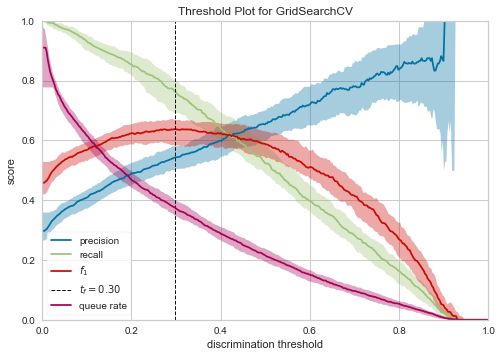

In [11]:
visualizer = DiscriminationThreshold(XGBcw)
visualizer.fit(X_train,y_train)
visualizer.poof()

# XGboost - Over Sampling, Scaling 

In [12]:
%%time
# Steps for pipeline
steps = [("smote", SMOTE(random_state=30)),
         ("scaler",MinMaxScaler(feature_range=(0,1))),
         ("model", XGBClassifier())]
pipe = pl(steps)

# Parameters
param_grid = dict(model__learning_rate = [0.10, 0.15, 0.20],
                  model__max_depth = [5, 10, 15, 20],
                  model__gamma = [ 0.1, 0.2, 0.3, 0.4 ],
                  model__colsample_bytree = [0.3, 0.4, 0.5 , 0.7])

# For CV in grid search
cv = StratifiedShuffleSplit(n_splits = 5, test_size = 0.2, random_state = 20)

# Setting up the grid search
XGBsmote = GridSearchCV(pipe, 
                       param_grid = param_grid, 
                       verbose = 4,
                       cv = cv,
                       n_jobs=-1,
                       scoring='average_precision',
                       iid=False)

# Training using CV
XGBsmote.fit(X_train, y_train)

Fitting 5 folds for each of 192 candidates, totalling 960 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed:  6.5min
[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed: 12.5min
[Parallel(n_jobs=-1)]: Done 605 tasks      | elapsed: 21.4min
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed: 34.6min
[Parallel(n_jobs=-1)]: Done 960 out of 960 | elapsed: 39.3min finished


CPU times: user 9.67 s, sys: 711 ms, total: 10.4 s
Wall time: 39min 19s


GridSearchCV(cv=StratifiedShuffleSplit(n_splits=5, random_state=20, test_size=0.2,
            train_size=None),
             error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('smote',
                                        SMOTE(k_neighbors=5, n_jobs=None,
                                              random_state=30,
                                              sampling_strategy='auto')),
                                       ('scaler',
                                        MinMaxScaler(copy=True,
                                                     feature_range=(0, 1))),
                                       ('model',
                                        XGBClassifier(base_score=0.5,
                                                      booster='gbtree',
                                                      colsa...
                                                      scale_pos_weight=1,
                                 

In [23]:
XGBsmote.best_params_

{'model__colsample_bytree': 0.3,
 'model__gamma': 0.3,
 'model__learning_rate': 0.1,
 'model__max_depth': 5}

#####################
Test data
#####################
F1:  0.5966850828729282
Cohen Kappa:  0.4571787947171765
Brier:  0.20753375977256575
LogLoss:  0.4334493328081795
              precision    recall  f1-score   support

           0       0.85      0.87      0.86      1033
           1       0.62      0.58      0.60       374

    accuracy                           0.79      1407
   macro avg       0.73      0.72      0.73      1407
weighted avg       0.79      0.79      0.79      1407



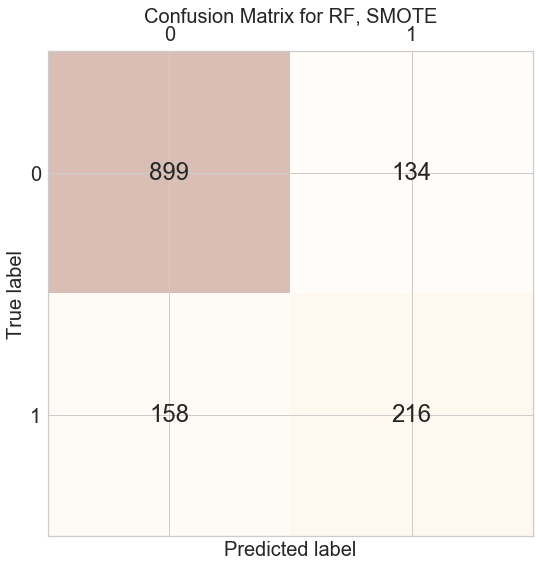

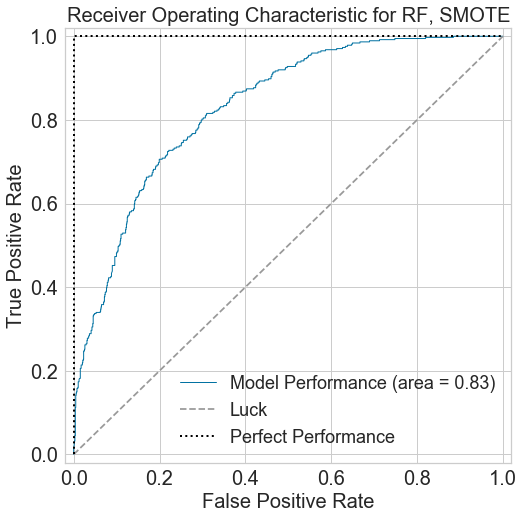

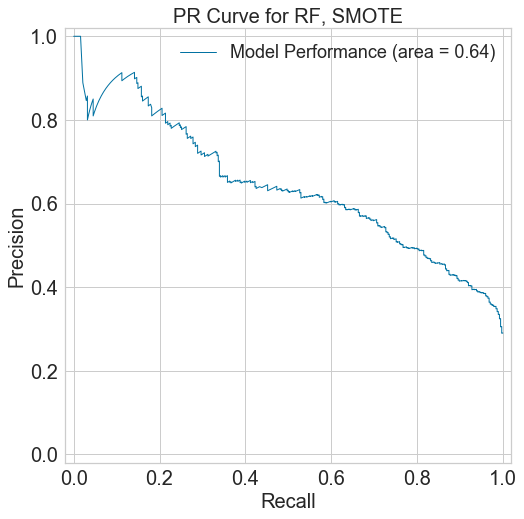

In [24]:
result(XGBsmote, X_train, y_train, X_test, y_test, train_result=False, clf_name="RF, SMOTE")